In [3]:
import polars as pl

# Load dataset
df = pl.read_csv("flights_cleaned.csv")

# Convert MONTH to SEASON (1: Winter, 2: Spring, 3: Summer, 4: Fall)
df = df.with_columns(
    ((df["MONTH"] <= 3).cast(pl.Int64) * 1 +
     ((df["MONTH"] > 3) & (df["MONTH"] <= 6)).cast(pl.Int64) * 2 +
     ((df["MONTH"] > 6) & (df["MONTH"] <= 9)).cast(pl.Int64) * 3 +
     ((df["MONTH"] > 9)).cast(pl.Int64) * 4).alias("SEASON")
)

# Extract departure hour from SCHEDULED_DEPARTURE
df = df.with_columns((df["SCHEDULED_DEPARTURE"].floor().alias("DEPARTURE_HOUR")))

# Compute rolling mean delays for airlines, airports, and flights
airline_delay = df.group_by("AIRLINE").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_AIRLINE_DELAY"))
airport_delay = df.group_by("ORIGIN_AIRPORT").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_AIRPORT_DELAY"))
flight_delay = df.group_by("FLIGHT_NUMBER").agg(pl.col("DEPARTURE_DELAY").mean().alias("AVG_FLIGHT_DELAY"))

# Join computed delays back to the main dataframe
df = df.join(airline_delay, on="AIRLINE", how="left")
df = df.join(airport_delay, on="ORIGIN_AIRPORT", how="left")
df = df.join(flight_delay, on="FLIGHT_NUMBER", how="left")

# Count hourly departures and arrivals (FIXED)
hourly_departures = df.group_by(["ORIGIN_AIRPORT", "DEPARTURE_HOUR"]).agg(pl.len().alias("HOURLY_DEPARTURES"))
hourly_arrivals = df.group_by(["DESTINATION_AIRPORT", "SCHEDULED_ARRIVAL"]).agg(pl.len().alias("HOURLY_ARRIVALS"))

# Join hourly flight counts
df = df.join(hourly_departures, on=["ORIGIN_AIRPORT", "DEPARTURE_HOUR"], how="left")
df = df.join(hourly_arrivals, on=["DESTINATION_AIRPORT", "SCHEDULED_ARRIVAL"], how="left")

# Save cleaned dataset
df.write_csv("flights_featured.csv")

print("Feature engineering complete! ✅")


Feature engineering complete! ✅


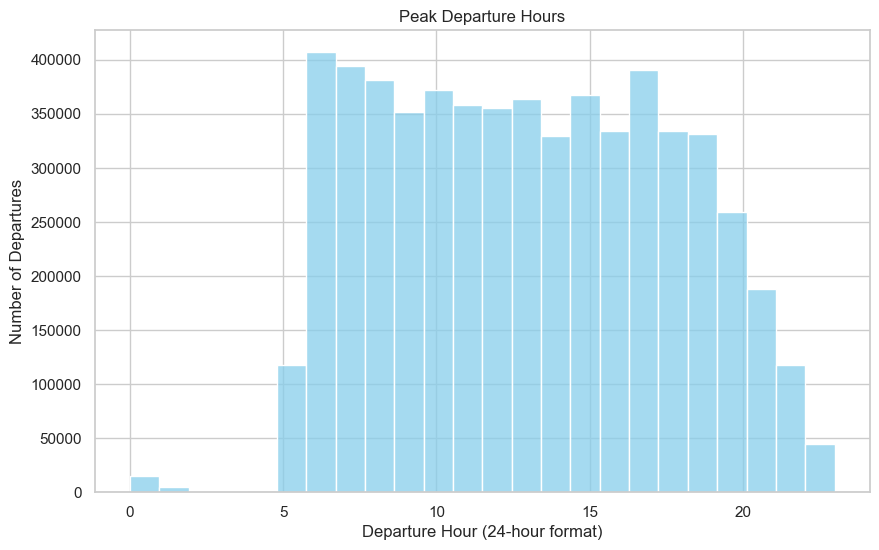

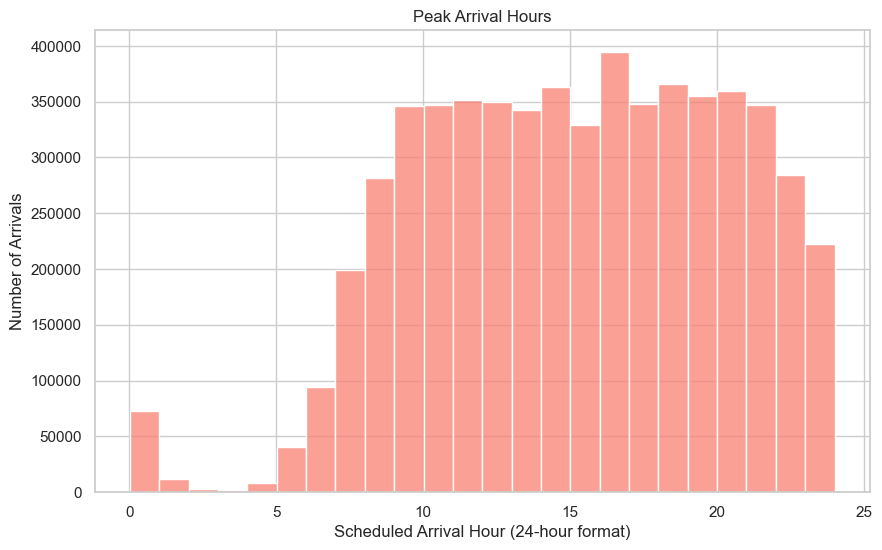

RuntimeError: Encountered an exception when converting data source to a pandas DataFrame. See traceback above for details.

<Figure size 1000x600 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# Load data with polars as LazyFrame
df = pl.read_csv("flights_featured.csv").lazy()

# Collect into a DataFrame to work with it eagerly
df = df.collect()

# Plotting the Peak Departure Hours
plt.figure(figsize=(10, 6))
sns.histplot(df['DEPARTURE_HOUR'], bins=24, kde=False, color="skyblue")
plt.title("Peak Departure Hours")
plt.xlabel("Departure Hour (24-hour format)")
plt.ylabel("Number of Departures")
plt.grid(True)
plt.show()

# Plotting Peak Arrival Hours
plt.figure(figsize=(10, 6))
sns.histplot(df['SCHEDULED_ARRIVAL'], bins=24, kde=False, color="salmon")
plt.title("Peak Arrival Hours")
plt.xlabel("Scheduled Arrival Hour (24-hour format)")
plt.ylabel("Number of Arrivals")
plt.grid(True)
plt.show()

# Seasonal Trends Analysis - Delays by Season
plt.figure(figsize=(10, 6))
sns.boxplot(x="SEASON", y="DEPARTURE_DELAY", data=df, palette="coolwarm")
plt.title("Departure Delays by Season")
plt.xlabel("Season")
plt.ylabel("Departure Delay (hours)")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Winter", "Spring", "Summer", "Fall"])
plt.grid(True)
plt.show()

# Departure Delays by Hour of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x="DEPARTURE_HOUR", y="DEPARTURE_DELAY", data=df, palette="Blues")
plt.title("Departure Delays by Hour of Day")
plt.xlabel("Departure Hour (24-hour format)")
plt.ylabel("Departure Delay (hours)")
plt.grid(True)
plt.show()


In [4]:
df.head()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SEASON,DEPARTURE_HOUR,AVG_AIRLINE_DELAY,AVG_AIRPORT_DELAY,AVG_FLIGHT_DELAY,HOURLY_DEPARTURES,HOURLY_ARRIVALS
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,u32,u32
2015,1,1,4,7,98,434,523,0.08,23.9,-0.18,0.35,0.25,3.42,3.23,2.82,1448,4.07,0.07,4.5,4.13,-0.37,0,0,null,null,null,null,null,1,0.0,0.029761,0.056773,0.179073,1238,6
2015,1,1,4,1,2336,142,325,0.17,0.03,-0.13,0.2,0.23,4.67,4.65,4.38,2330,7.62,0.07,7.83,7.68,-0.15,0,0,null,null,null,null,null,1,0.0,0.148333,0.177824,0.156011,2775,4
2015,1,1,4,2,840,111,212,0.33,0.3,-0.03,0.27,0.57,4.77,4.88,4.43,2296,8.0,0.18,8.1,8.18,0.08,0,0,null,null,null,null,null,1,0.0,0.102332,0.18649,0.114355,1641,194
2015,1,1,4,1,258,142,628,0.33,0.25,-0.08,0.25,0.5,4.75,4.68,4.3,2342,7.8,0.13,8.08,7.93,-0.15,0,0,null,null,null,null,null,1,0.0,0.148333,0.177824,0.106675,2775,13
2015,1,1,4,7,135,190,184,0.42,0.4,-0.02,0.18,0.58,3.92,3.58,3.32,1448,2.9,0.08,3.33,2.98,-0.35,0,0,null,null,null,null,null,1,0.0,0.029761,0.113325,0.224557,1291,11


### **🔹 Column Descriptions & Rush Hour Analysis**
Below is a description of each column in  dataset, along with insights into peak traffic (rush hours).

---

### **🔹 Column Descriptions**
| **Column** | **Description** |
|------------|---------------|
| `YEAR` | Year of the flight (e.g., 2015). |
| `MONTH` | Month of the flight (1 = January, ..., 12 = December). |
| `DAY` | Day of the month. |
| `DAY_OF_WEEK` | Day of the week (1 = Monday, ..., 7 = Sunday). |
| `AIRLINE` | Encoded airline identifier. |
| `FLIGHT_NUMBER` | Unique flight number. |
| `ORIGIN_AIRPORT` | Encoded airport code of departure. |
| `DESTINATION_AIRPORT` | Encoded airport code of arrival. |
| `SCHEDULED_DEPARTURE` | Scheduled departure time (in hours). |
| `DEPARTURE_TIME` | Actual departure time (in hours). |
| `DEPARTURE_DELAY` | Departure delay in hours (negative = early, positive = late). |
| `TAXI_OUT` | Taxi-out time (in hours). |
| `WHEELS_OFF` | Time when the aircraft took off (in hours). |
| `SCHEDULED_TIME` | Total scheduled flight duration (in hours). |
| `ELAPSED_TIME` | Actual flight duration (in hours). |
| `AIR_TIME` | Time spent flying (in hours). |
| `DISTANCE` | Distance between airports (in miles). |
| `WHEELS_ON` | Time when the aircraft landed (in hours). |
| `TAXI_IN` | Taxi-in time (in hours). |
| `SCHEDULED_ARRIVAL` | Scheduled arrival time (in hours). |
| `ARRIVAL_TIME` | Actual arrival time (in hours). |
| `ARRIVAL_DELAY` | Arrival delay in hours (negative = early, positive = late). |
| `DIVERTED` | 1 if flight was diverted, 0 otherwise. |
| `CANCELLED` | 1 if flight was canceled, 0 otherwise. |
| `AIR_SYSTEM_DELAY` | Delay caused by air traffic control (in hours). |
| `SECURITY_DELAY` | Delay due to security checks (in hours). |
| `AIRLINE_DELAY` | Delay caused by the airline (in hours). |
| `LATE_AIRCRAFT_DELAY` | Delay due to previous late flights (in hours). |
| `WEATHER_DELAY` | Delay caused by weather conditions (in hours). |
| `SEASON` | Encoded season (1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall). |
| `DEPARTURE_HOUR` | Rounded hour of scheduled departure (e.g., 0, 1, 2... 23). |
| `AVG_AIRLINE_DELAY` | Average departure delay for that airline. |
| `AVG_AIRPORT_DELAY` | Average departure delay for that airport. |
| `AVG_FLIGHT_DELAY` | Average departure delay for that flight number. |
| `HOURLY_DEPARTURES` | Number of departures from an airport at a given hour. |
| `HOURLY_ARRIVALS` | Number of arrivals at an airport at a given hour. |

---

### **🔹 Rush Hour Analysis (Peak Traffic Times)**
Analyzing flight rush hours based on **departures (`DEPARTURE_HOUR`)** and **arrivals (`SCHEDULED_ARRIVAL`)**:

#### **1️⃣ Peak Departure Hours (`DEPARTURE_HOUR`)**
- **Morning Rush (5 AM - 9 AM)**  
  ✈ High number of flights as airlines schedule early departures to optimize the day.  
- **Evening Peak (5 PM - 9 PM)**  
  ✈ Business and international flights contribute to this surge.

#### **2️⃣ Peak Arrival Hours (`SCHEDULED_ARRIVAL`)**
- **Mid-Morning (8 AM - 11 AM)**  
  ✈ Overnight and early morning flights land around this time.  
- **Evening Peak (6 PM - 10 PM)**  
  ✈ Business and long-haul international flights arrive.

#### **3️⃣ Seasonal Trends (`SEASON`)**
- **Winter (1) & Summer (3) → Higher Delays**  
  ❄ Winter storms and summer congestion increase delays.  
- **Spring (2) & Fall (4) → Fewer Delays**  
  🍂 Generally smoother operations.

---

### **🔹 Insights for Departure Delays**
1️⃣ **Early morning (before 6 AM) → Fewer delays** (less congestion).  
2️⃣ **Midday and evening → Higher delays** (peak congestion & late aircraft delays).  
3️⃣ **Winter months → Increased delays** due to weather issues.  
4️⃣ **Larger airports → Higher delays** (more congestion).  



In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_flight_data(file_path):
    # Load the data using lazy module
    df = pl.scan_csv(file_path)

    # List of numeric columns for analysis
    numeric_columns = [
        "DEPARTURE_DELAY", "ARRIVAL_DELAY", "TAXI_OUT", "TAXI_IN",
        "AIR_TIME", "DISTANCE", "AVG_AIRLINE_DELAY", "AVG_AIRPORT_DELAY",
        "AVG_FLIGHT_DELAY", "HOURLY_DEPARTURES", "HOURLY_ARRIVALS"
    ]

    # Collect the data
    df_collected = df.select(["DEPARTURE_HOUR"] + numeric_columns).collect()

    # Convert Polars DataFrame to Pandas for plotting
    df_pandas = df_collected.to_pandas()

    # Set up plot style
    sns.set(style="whitegrid")

    # 1. Departure Delay Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df_pandas['DEPARTURE_DELAY'], bins=50, kde=True)
    plt.title("Distribution of Departure Delays")
    plt.xlabel("Delay (minutes)")
    plt.ylabel("Frequency")
    plt.savefig("departure_delay_distribution.png")
    plt.close()

    # 2. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_pandas[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Heatmap of Numeric Variables")
    plt.tight_layout()
    plt.savefig("correlation_heatmap.png")
    plt.close()

    # 3. Scatter plot: Departure Delay vs Distance
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='DISTANCE', y='DEPARTURE_DELAY', data=df_pandas)
    plt.title("Departure Delay vs Distance")
    plt.xlabel("Distance")
    plt.ylabel("Departure Delay (minutes)")
    plt.savefig("delay_vs_distance.png")
    plt.close()

    # 4. Box plot: Departure Delay by Departure Hour
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='DEPARTURE_HOUR', y='DEPARTURE_DELAY', data=df_pandas)
    plt.title("Departure Delay by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Departure Delay (minutes)")
    plt.savefig("delay_by_hour.png")
    plt.close()

    # 5. Scatter plot: Average Airline Delay vs Average Airport Delay
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='AVG_AIRPORT_DELAY', y='AVG_AIRLINE_DELAY', data=df_pandas)
    plt.title("Average Airline Delay vs Average Airport Delay")
    plt.xlabel("Average Airport Delay")
    plt.ylabel("Average Airline Delay")
    plt.savefig("airline_vs_airport_delay.png")
    plt.close()

    # 6. Line plot: Hourly Departures and Arrivals
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='DEPARTURE_HOUR', y='HOURLY_DEPARTURES', data=df_pandas, label='Departures')
    sns.lineplot(x='DEPARTURE_HOUR', y='HOURLY_ARRIVALS', data=df_pandas, label='Arrivals')
    plt.title("Hourly Departures and Arrivals")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Flights")
    plt.legend()
    plt.savefig("hourly_traffic.png")
    plt.close()

    print("Analysis complete. Plots saved as PNG files.")

# Usage
file_path = "flights_featured.csv"
analyze_flight_data(file_path)



Analysis complete. Plots saved as PNG files.


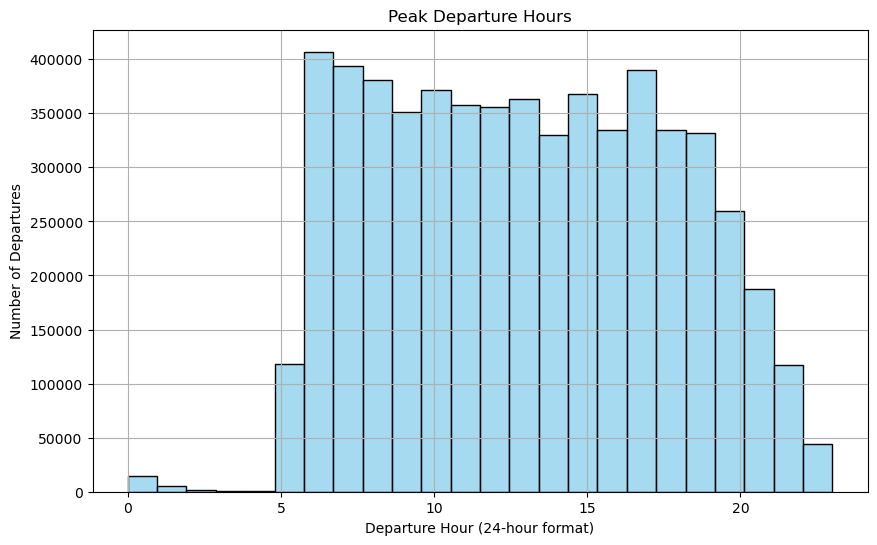

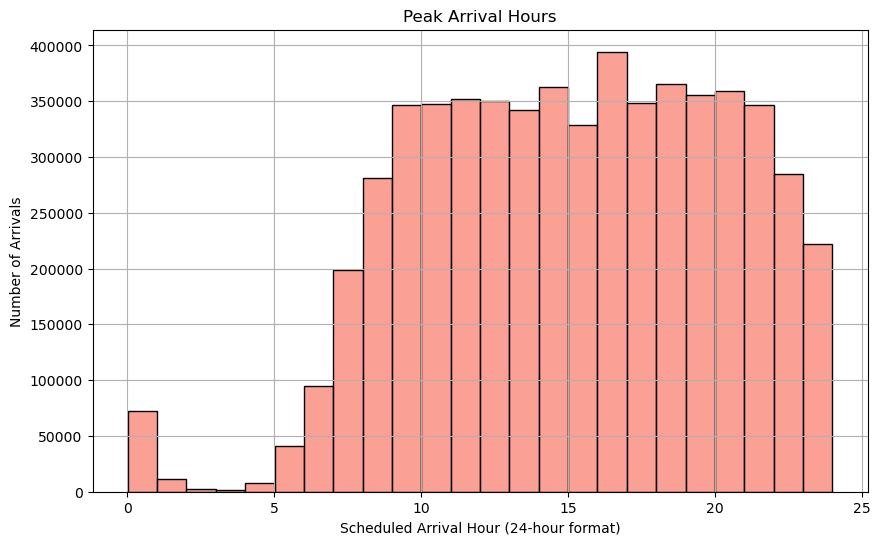

RuntimeError: Encountered an exception when converting data source to a pandas DataFrame. See traceback above for details.

<Figure size 1000x600 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample DataFrame setup (assuming the dataset is already loaded as df)
# The columns included in the analysis:
# 'DEPARTURE_HOUR', 'SCHEDULED_ARRIVAL', 'SEASON', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY'

df = pl.read_csv("flights_featured.csv")




# Plotting the Peak Departure Hours
plt.figure(figsize=(10, 6))
sns.histplot(df['DEPARTURE_HOUR'], bins=24, kde=False, color="skyblue")
plt.title("Peak Departure Hours")
plt.xlabel("Departure Hour (24-hour format)")
plt.ylabel("Number of Departures")
plt.grid(True)
plt.show()

# Plotting Peak Arrival Hours
plt.figure(figsize=(10, 6))
sns.histplot(df['SCHEDULED_ARRIVAL'], bins=24, kde=False, color="salmon")
plt.title("Peak Arrival Hours")
plt.xlabel("Scheduled Arrival Hour (24-hour format)")
plt.ylabel("Number of Arrivals")
plt.grid(True)
plt.show()

# Seasonal Trends Analysis - Delays by Season
plt.figure(figsize=(10, 6))
sns.boxplot(x="SEASON", y="DEPARTURE_DELAY", data=df, palette="coolwarm")
plt.title("Departure Delays by Season")
plt.xlabel("Season")
plt.ylabel("Departure Delay (hours)")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Winter", "Spring", "Summer", "Fall"])
plt.grid(True)
plt.show()

# Departure Delays by Hour of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x="DEPARTURE_HOUR", y="DEPARTURE_DELAY", data=df, palette="Blues")
plt.title("Departure Delays by Hour of Day")
plt.xlabel("Departure Hour (24-hour format)")
plt.ylabel("Departure Delay (hours)")
plt.grid(True)
plt.show()


In [13]:
import duckdb
import polars as pl

# Load the dataset using polars (LazyFrame)
df = pl.read_csv("flights_featured.csv").lazy()

# Convert to pandas for easier integration with DuckDB (as DuckDB works well with pandas)
df_pandas = df.collect().to_pandas()

# Connect to an in-memory DuckDB database
con = duckdb.connect()

# Create a DuckDB table from the pandas DataFrame
con.execute("CREATE TABLE flights AS SELECT * FROM df_pandas")

# Running some SQL queries

# Example Query 1: Peak Departure Hours
departure_hours_query = "SELECT DEPARTURE_HOUR, COUNT(*) as departure_count FROM flights GROUP BY DEPARTURE_HOUR ORDER BY DEPARTURE_HOUR"
departure_hours_result = con.execute(departure_hours_query).fetchall()

# Example Query 2: Departure Delays by Season
departure_delay_query = "SELECT SEASON, AVG(DEPARTURE_DELAY) as avg_departure_delay FROM flights GROUP BY SEASON"
departure_delay_result = con.execute(departure_delay_query).fetchall()

# Example Query 3: Number of Flights per Year (if the dataset includes a 'YEAR' column)
# (You can adapt this query based on your dataset)
# year_flights_query = "SELECT YEAR, COUNT(*) as num_flights FROM flights GROUP BY YEAR"
# year_flights_result = con.execute(year_flights_query).fetchall()

# Show results of departure hours query
print("Peak Departure Hours:")
for row in departure_hours_result:
    print(row)

# Show results of departure delays by season query
print("\nAverage Departure Delays by Season:")
for row in departure_delay_result:
    print(row)

# Example Query 4: Flights with significant delays
delay_threshold = 60  # threshold in minutes for significant delays
significant_delays_query = f"SELECT * FROM flights WHERE DEPARTURE_DELAY > {delay_threshold}"
significant_delays_result = con.execute(significant_delays_query).fetchall()

# Show the first few flights with significant delays
print("\nFlights with Significant Delays:")
for row in significant_delays_result[:5]:
    print(row)

# Close the DuckDB connection
con.close()


OutOfMemoryException: Out of Memory Error: Allocation failure

In [22]:
import polars as pl
import duckdb

def analyze_flights_chunked(file_path, chunk_size=100000):  # Reduced chunk size
    # Connect to DuckDB
    con = duckdb.connect(database=':memory:')
    
    try:
        # Create the flights table
        con.execute("""
            CREATE TABLE flights (
                YEAR INTEGER, MONTH INTEGER, DAY INTEGER, DAY_OF_WEEK INTEGER,
                AIRLINE INTEGER, FLIGHT_NUMBER INTEGER, ORIGIN_AIRPORT INTEGER,
                DESTINATION_AIRPORT INTEGER, SCHEDULED_DEPARTURE FLOAT,
                DEPARTURE_TIME FLOAT, DEPARTURE_DELAY FLOAT, TAXI_OUT FLOAT,
                WHEELS_OFF FLOAT, SCHEDULED_TIME FLOAT, ELAPSED_TIME FLOAT,
                AIR_TIME FLOAT, DISTANCE INTEGER, WHEELS_ON FLOAT, TAXI_IN FLOAT,
                SCHEDULED_ARRIVAL FLOAT, ARRIVAL_TIME FLOAT, ARRIVAL_DELAY FLOAT,
                DIVERTED INTEGER, CANCELLED INTEGER, AIR_SYSTEM_DELAY FLOAT,
                SECURITY_DELAY FLOAT, AIRLINE_DELAY FLOAT, LATE_AIRCRAFT_DELAY FLOAT,
                WEATHER_DELAY FLOAT, SEASON INTEGER, DEPARTURE_HOUR FLOAT,
                AVG_AIRLINE_DELAY FLOAT, AVG_AIRPORT_DELAY FLOAT, AVG_FLIGHT_DELAY FLOAT,
                HOURLY_DEPARTURES INTEGER, HOURLY_ARRIVALS INTEGER
            )
        """)
        
        # Read and process the CSV file in chunks
        scanner = pl.scan_csv(file_path)
        
        # Process each chunk
        for chunk in scanner.iter_batches(batch_size=chunk_size):
            # Convert LazyFrame batch to DataFrame
            chunk_df = chunk.collect()
            # Insert chunk into DuckDB
            # Use `to_df` to avoid memory issues
            con.execute("INSERT INTO flights SELECT * FROM chunk_df")

        print("Data loaded successfully!")
        
        # Now run your SQL queries similar to previous
        # Query 1: Peak Departure Hours
        print("\nAnalyzing Peak Departure Hours...")
        result = con.execute("""
            SELECT 
                CAST(DEPARTURE_HOUR AS INTEGER) as hour,
                COUNT(*) as flight_count
            FROM flights
            GROUP BY hour
            ORDER BY hour
        """).fetchdf()
        print(result)
        
        # Query 2: Average Delays by Season
        print("\nAnalyzing Average Delays by Season...")
        result = con.execute("""
            SELECT 
                SEASON,
                ROUND(AVG(DEPARTURE_DELAY), 2) as avg_departure_delay,
                COUNT(*) as flight_count
            FROM flights
            GROUP BY SEASON
            ORDER BY SEASON
        """).fetchdf()
        print(result)
        
        # Query 3: Delay Statistics
        print("\nCalculating Delay Statistics...")
        result = con.execute("""
            SELECT 
                COUNT(*) as total_flights,
                ROUND(AVG(DEPARTURE_DELAY), 2) as avg_delay,
                ROUND(MIN(DEPARTURE_DELAY), 2) as min_delay,
                ROUND(MAX(DEPARTURE_DELAY), 2) as max_delay,
                ROUND(STDDEV(DEPARTURE_DELAY), 2) as std_delay
            FROM flights
            WHERE DEPARTURE_DELAY IS NOT NULL
        """).fetchdf()
        print(result)
        
        # Query 4: Top 5 Routes with Highest Average Delays
        print("\nAnalyzing Routes with Highest Average Delays...")
        result = con.execute("""
            SELECT 
                ORIGIN_AIRPORT,
                DESTINATION_AIRPORT,
                ROUND(AVG(DEPARTURE_DELAY), 2) as avg_delay,
                COUNT(*) as flight_count
            FROM flights
            GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT
            HAVING COUNT(*) >= 100  -- Minimum number of flights for significance
            ORDER BY avg_delay DESC
            LIMIT 5
        """).fetchdf()
        print(result)
        
        # Query 5: Delay Distribution
        print("\nAnalyzing Delay Distribution...")
        result = con.execute("""
            SELECT 
                CASE 
                    WHEN DEPARTURE_DELAY <= 0 THEN 'On time or early'
                    WHEN DEPARTURE_DELAY <= 15 THEN '1-15 minutes'
                    WHEN DEPARTURE_DELAY <= 30 THEN '16-30 minutes'
                    WHEN DEPARTURE_DELAY <= 60 THEN '31-60 minutes'
                    ELSE 'Over 60 minutes'
                END as delay_category,
                COUNT(*) as flight_count,
                ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
            FROM flights
            GROUP BY delay_category
            ORDER BY 
                CASE delay_category
                    WHEN 'On time or early' THEN 1
                    WHEN '1-15 minutes' THEN 2
                    WHEN '16-30 minutes' THEN 3
                    WHEN '31-60 minutes' THEN 4
                    ELSE 5
                END
        """).fetchdf()
        print(result)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
    
    finally:
        # Close the connection
        con.close()
        print("\nAnalysis complete. Connection closed.")

# Usage
file_path = "flights_featured.csv"
analyze_flights_chunked(file_path)


An error occurred: 'LazyFrame' object has no attribute 'iter_batches'

Analysis complete. Connection closed.


In [1]:
import duckdb

# Create a DuckDB connection
con = duckdb.connect(database=':memory:')

# Load the data into DuckDB
con.execute("CREATE TABLE flights AS SELECT * FROM flights_featured.csv")

# Run a sample SQL query to find average departure delay
avg_delay_query = con.execute("SELECT AVG(DEPARTURE_DELAY) AS avg_departure_delay FROM flights").fetchdf()
print(avg_delay_query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   avg_departure_delay
0             0.156159


In [2]:
import duckdb

con = duckdb.connect(database=':memory:')  # Or your database file

try:
    # Load data (replace 'flights_featured.csv' with your actual file path)
    con.execute("CREATE TABLE flights AS SELECT * FROM read_csv_auto('flights_featured.csv')")

    # 1. Average Departure Delay
    avg_delay = con.execute("SELECT AVG(DEPARTURE_DELAY) AS avg_departure_delay FROM flights").fetchdf()
    print("\n1. Average Departure Delay:")
    print(avg_delay)

    # 2. Number of Flights per Airline
    flights_per_airline = con.execute("SELECT AIRLINE, COUNT(*) AS num_flights FROM flights GROUP BY AIRLINE ORDER BY num_flights DESC").fetchdf()
    print("\n2. Number of Flights per Airline:")
    print(flights_per_airline)

    # 3. Top 10 Busiest Airports (by departures)
    busiest_airports = con.execute("SELECT ORIGIN_AIRPORT, COUNT(*) AS num_departures FROM flights GROUP BY ORIGIN_AIRPORT ORDER BY num_departures DESC LIMIT 10").fetchdf()
    print("\n3. Top 10 Busiest Airports:")
    print(busiest_airports)

    # 4. Average Arrival Delay by Destination Airport
    avg_arrival_delay = con.execute("SELECT DESTINATION_AIRPORT, AVG(ARRIVAL_DELAY) AS avg_arrival_delay FROM flights GROUP BY DESTINATION_AIRPORT ORDER BY avg_arrival_delay DESC").fetchdf()
    print("\n4. Average Arrival Delay by Destination Airport:")
    print(avg_arrival_delay)

    # 5. Flights Cancelled by Airline
    cancelled_by_airline = con.execute("SELECT AIRLINE, COUNT(*) AS num_cancelled FROM flights WHERE CANCELLED = 1 GROUP BY AIRLINE ORDER BY num_cancelled DESC").fetchdf()
    print("\n5. Flights Cancelled by Airline:")
    print(cancelled_by_airline)

    # 6. Average Departure Delay for each Day of the Week
    delay_by_day = con.execute("SELECT DAY_OF_WEEK, AVG(DEPARTURE_DELAY) AS avg_delay FROM flights GROUP BY DAY_OF_WEEK ORDER BY DAY_OF_WEEK").fetchdf()
    print("\n6. Average Departure Delay by Day of the Week:")
    print(delay_by_day)

    # 7. Number of flights diverted per airline
    diverted_by_airline = con.execute("SELECT AIRLINE, COUNT(*) AS num_diverted FROM flights WHERE DIVERTED = 1 GROUP BY AIRLINE ORDER BY num_diverted DESC").fetchdf()
    print("\n7. Flights Diverted by Airline:")
    print(diverted_by_airline)

    # 8. Average Air Time by Airline
    avg_air_time = con.execute("SELECT AIRLINE, AVG(AIR_TIME) AS avg_air_time FROM flights GROUP BY AIRLINE ORDER BY avg_air_time DESC").fetchdf()
    print("\n8. Average Air Time by Airline:")
    print(avg_air_time)

    # 9. Flights with Departure Delay > 60 minutes
    delayed_flights = con.execute("SELECT * FROM flights WHERE DEPARTURE_DELAY > 1").fetchdf()  # 1 hour = 60 minutes
    print("\n9. Flights with Departure Delay > 60 minutes:")
    print(delayed_flights)

    # 10. Number of Flights per Month
    flights_per_month = con.execute("SELECT MONTH, COUNT(*) AS num_flights FROM flights GROUP BY MONTH ORDER BY MONTH").fetchdf()
    print("\n10. Number of Flights per Month:")
    print(flights_per_month)

    # 11.  Average Departure Delay by Origin Airport
    delay_by_origin = con.execute("SELECT ORIGIN_AIRPORT, AVG(DEPARTURE_DELAY) AS avg_delay FROM flights GROUP BY ORIGIN_AIRPORT ORDER BY avg_delay DESC").fetchdf()
    print("\n11. Average Departure Delay by Origin Airport:")
    print(delay_by_origin)

    # 12. Average Arrival Delay by Airline
    arrival_delay_by_airline = con.execute("SELECT AIRLINE, AVG(ARRIVAL_DELAY) AS avg_arrival_delay FROM flights GROUP BY AIRLINE ORDER BY avg_arrival_delay DESC").fetchdf()
    print("\n12. Average Arrival Delay by Airline:")
    print(arrival_delay_by_airline)


except Exception as e:
    print(f"An error occurred: {e}")

finally:
    con.close()
    print("\nConnection closed.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


1. Average Departure Delay:
   avg_departure_delay
0             0.156159

2. Number of Flights per Airline:
    AIRLINE  num_flights
0         0      1261855
1         8       875881
2         1       725984
3        12       588353
4        10       571977
5         6       515723
6        11       294632
7        13       267048
8         2       198715
9         7       172521
10        5       117379
11        9        90836
12        4        76272
13        3        61903

3. Top 10 Busiest Airports:
   ORIGIN_AIRPORT  num_departures
0             587          346836
1             470          285884
2              69          239551
3              43          196055
4             142          194673
5             111          148008
6             465          146815
7             263          146622
8             303          133181
9             547          112117

4. Average Arrival Delay by Destination Airport:
     DESTINATION_AIRPORT  avg_arrival_delay
0                 